In [56]:
!nvidia-smi

Sun Nov 16 09:26:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   77C    P0             34W /   70W |     758MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
from datasets import load_dataset

In [11]:
# Load dataset:
dataset = load_dataset("maartengr/arxiv_nlp")["train"]

# Extract metadata
abstracts = dataset["Abstracts"]
titles = dataset["Titles"]

In [6]:
dataset

Dataset({
    features: ['Titles', 'Abstracts', 'Years', 'Categories'],
    num_rows: 44949
})

## Text Clustering:

### 1. Embedding Documents

In [12]:
from sentence_transformers import SentenceTransformer

# Create an embedding model for each abstract
embedding_model = SentenceTransformer("thenlper/gte-small")
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1405 [00:00<?, ?it/s]

In [13]:
embeddings.shape

(44949, 384)

### 2. Reducing the Dimensionality of Embeddings:

In [14]:
from umap import UMAP

In [15]:
# We reduce the input embeddings from 384 dimensions to 5 dimensions
umap_model = UMAP(
    n_components=5,
    min_dist=0.0,
    metric="cosine",
    random_state=42,
)

reduced_embeddings = umap_model.fit_transform(embeddings)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### 3. Cluster the REduced Enbeddings:

#### HDBSCAN - Heirarchical Density Based Spatial Clustering of Applications with Noise

In [16]:
from hdbscan import HDBSCAN

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [18]:
# We fit the model and extract the clusters

hdbscan_model = HDBSCAN(
    min_cluster_size=50, 
    metric = 'euclidean',
    cluster_selection_method='eom'
).fit(reduced_embeddings)

clusters = hdbscan_model.labels_

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [19]:
len(set(clusters))

155

In [24]:
index

np.int64(313)

In [26]:
import numpy as np

cluster = 0

for index in np.where(clusters == cluster)[0][:3]:
    print(abstracts[int(index)][:300])

  This works aims to design a statistical machine translation from English text
to American Sign Language (ASL). The system is based on Moses tool with some
modifications and the results are synthesized through a 3D avatar for
interpretation. First, we translate the input text to gloss, a written fo
  Researches on signed languages still strongly dissociate lin- guistic issues
related on phonological and phonetic aspects, and gesture studies for
recognition and synthesis purposes. This paper focuses on the imbrication of
motion and meaning for the analysis, synthesis and evaluation of sign lang
  Modern computational linguistic software cannot produce important aspects of
sign language translation. Using some researches we deduce that the majority of
automatic sign language translation systems ignore many aspects when they
generate animation; therefore the interpretation lost the truth inf


In [27]:
import pandas as pd

# Reduce 384 dimesional embeddings into two dimesinons for easy visualization

reduced_embeddings = UMAP(
    n_components=2,
    min_dist=0.0,
    metric="cosine",
    random_state=42,
).fit_transform(embeddings)

# Create dataframe

df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
df["titles"] = titles
df["clusters"] = [str(c) for c in clusters]

# select outliers and non-outliers(clusters)

to_plot = df.loc[df["clusters"] != "-1", :]
outliers = df.loc[df["clusters"] == "-1", :]

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


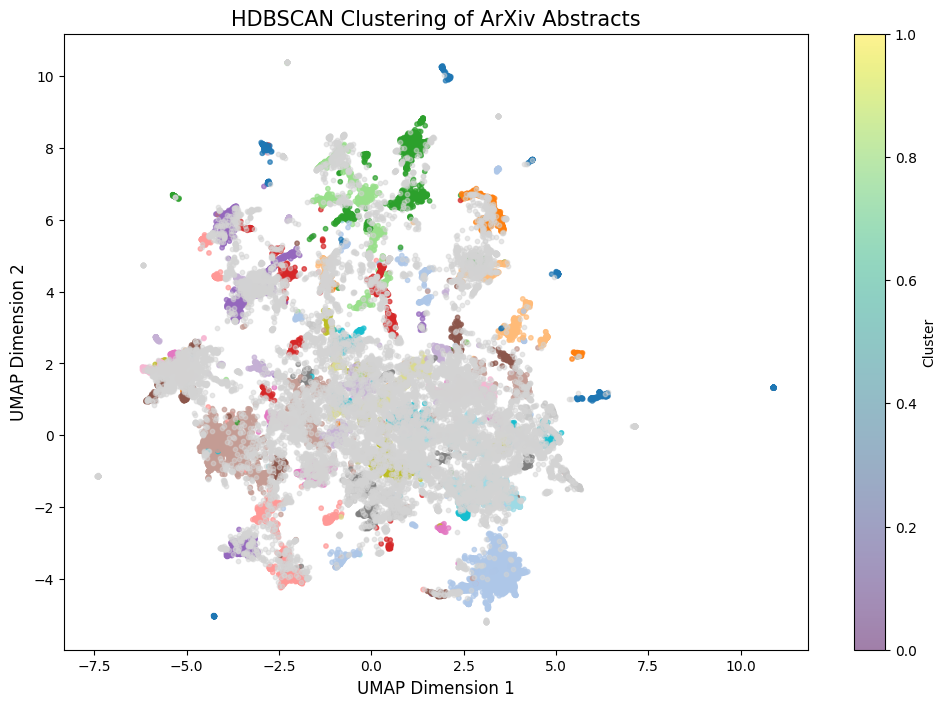

In [29]:
import matplotlib.pyplot as plt

# Plot outliers and non-outliers separately

plt.figure(figsize=(12, 8))
plt.scatter(
    to_plot["x"],
    to_plot["y"],
    c=to_plot["clusters"].astype(int),
    cmap="tab20",
    s=10,
    alpha=0.7,
)
plt.scatter(
    outliers["x"],
    outliers["y"],
    c="lightgrey",
    s=10,
    alpha=0.5,
)
plt.title("HDBSCAN Clustering of ArXiv Abstracts", fontsize=15)
plt.xlabel("UMAP Dimension 1", fontsize=12)
plt.ylabel("UMAP Dimension 2", fontsize=12)
plt.colorbar(label="Cluster")   
plt.show()  

### From Text Clustering to Topic Modeling

#### BERTopic: A modular Topic Modeling Framework
##### 1. Embed documents (SBERT)
##### 2. Reduce Dimensinality (UMAP)
##### 3. Cluster compressed embeddings (HDBSCAN)
##### 4. Create a class based bag of words (count vectorizer)
##### 5. Weigh terms(c- TF - IDF)

In [36]:
# !pip install bertopic   

In [37]:
from bertopic import BERTopic

# Train our model with our previuosly defined models

topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True,
).fit(abstracts, embeddings)

2025-11-16 09:09:27,481 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-16 09:10:20,902 - BERTopic - Dimensionality - Completed ✓
2025-11-16 09:10:20,904 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-16 09:10:27,670 - BERTopic - Cluster - Completed ✓
2025-11-16 09:10:27,685 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-16 09:10:31,577 - BERTopic - Representation - Completed ✓


In [38]:
topic_model.get_topic_info()

Topic  Count                                           Name  \
0       -1  14210                               -1_of_the_and_to   
1        0   2316                   0_speech_asr_recognition_end   
2        1   2183                 1_question_qa_questions_answer   
3        2    941                 2_translation_nmt_machine_bleu   
4        3    880  3_summarization_summaries_summary_abstractive   
..     ...    ...                                            ...   
150    149     54          149_sentence_embeddings_sts_embedding   
151    150     54            150_gans_gan_adversarial_generation   
152    151     54         151_coherence_discourse_paragraph_text   
153    152     53                   152_chatgpt_its_openai_tasks   
154    153     52    153_opinion_reviews_summaries_summarization   

                                        Representation  \
0    [of, the, and, to, in, we, language, for, that...   
1    [speech, asr, recognition, end, acoustic, spea...   
2    [question, qa, questions, answer, answering, a...   
3    [translation, nmt, machine, bleu, neural, engl...   
4    [summarization, summaries, summary, abstractiv...   
..                                                 ...   
150  [sentence, embeddings, sts, embedding, similar...   
151  [gans, gan, adversarial, generation, generativ...   
152  [coherence, discourse, paragraph, text, cohesi...   
153  [chatgpt, its, openai, tasks, has, ai, capabil...   
154  [opinion, reviews, summaries, summarization, r...   

                                   Representative_Docs  
0    [  GPT-$3$ has attracted lots of attention due...  
1    [  The speech chain mechanism integrates autom...  
2    [  Text-based Question Generation (QG) aims at...  
3    [  Recently, the development of neural machine...  
4    [  Sentence summarization shortens given texts...  
..                                                 ...  
150  [  Sentence representation at the semantic lev...  
151  [  Text generation is of particular interest i...  
152  [  While there has been significant progress t...  
153  [  Over the last few years, large language mod...  
154  [  When faced with a large number of product r...  

[155 rows x 5 columns]

In [40]:
topic_model.get_topic(0)

[('speech', np.float64(0.028208883288593535)),
 ('asr', np.float64(0.018842312810416793)),
 ('recognition', np.float64(0.01351959051292077)),
 ('end', np.float64(0.009745990895354896)),
 ('acoustic', np.float64(0.009384710004108402)),
 ('speaker', np.float64(0.006877359138616964)),
 ('audio', np.float64(0.006785262733110495)),
 ('the', np.float64(0.006370412745274845)),
 ('error', np.float64(0.00634287314665723)),
 ('automatic', np.float64(0.0063065026437668335))]

In [41]:
topic_model.find_topics("topic_model")

([24, -1, 32, 84, 38],
 [np.float32(0.9213355),
  np.float32(0.8840989),
  np.float32(0.8783059),
  np.float32(0.87807596),
  np.float32(0.87333405)])

In [42]:
topic_model.get_topic(22)

[('attention', np.float64(0.03425435940968105)),
 ('transformer', np.float64(0.026740235939068376)),
 ('transformers', np.float64(0.016843458037420853)),
 ('heads', np.float64(0.011400481311768474)),
 ('self', np.float64(0.01135006082599855)),
 ('long', np.float64(0.011072434008226504)),
 ('memory', np.float64(0.009125124196811406)),
 ('head', np.float64(0.00854137687033938)),
 ('sequences', np.float64(0.008518917815109195)),
 ('sequence', np.float64(0.008157765361964789))]

In [44]:
topic_model.topics_[titles.index("BERTopic: Neural topic modeling with a class-based TF_IDF procedure")]

ValueError: 

In [55]:
fig = topic_model.visualize_documents(
    list(titles),                       # ← FIX: convert HF dataset column to list
    reduced_embeddings=reduced_embeddings,
    width=1200,
    hide_annotations=True
)

fig.update_layout(legend=dict(font=dict(size=16)))   # ← legend font fix
fig.show()


In [51]:
# Visualize barchart with ranked keywords
topic_model.visualize_barchart()

# visualize relationships between topics
topic_model.visualize_heatmap(n_clusters=30)

# Visual the potential heirarchical structure of topics
topic_model.visualize_hierarchy()
